Consider $N$ to be an integer number with $p$ and $q$ being its prime factors, so that $N - pq = 0$.

Now, we can define the cost function as,
$$f(x,y) = (N-xy)^2$$

The exact length of the factors is previously unknown. However, the number of qubits sufficient
to represent the prime factors in binary form requires the following amount of qubits:
$$n_x=m\big( \lfloor \sqrt{N} \rfloor \big) - 1 \text{\quad and \quad} n_y = m \bigg( \lfloor N/3 \rfloor \bigg) - 1$$

The solution of the factorization problem is encoded in the ground state of a Hamiltonian
$$H_f = \bigg[ NI - \bigg( \sum_{l=1}^{n_x} 2^l x_l + I \bigg) \bigg( \sum_{m=1}^{n_y} 2^m x_m + I \bigg) \bigg]^2$$
where $x_l = \dfrac{I - \sigma_l^z}{2}$, and $y_m = \dfrac{I - \sigma_m^z}{2}$.

In the simple case $N = 21$, $n_x=1$ and $n_y=2$.

## 1. Analytically

In [304]:
from itertools import product

import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from scipy.optimize import minimize, OptimizeResult
import sympy as sp
from sympy.physics.quantum import Dagger, TensorProduct

In [305]:
def to_polar(M):
    return M.applyfunc(lambda z: round(sp.Abs(z),3) * sp.exp(sp.I * round(sp.arg(z).evalf(),3)))

def plot_quantum_state_probabilities(psi, top_n=None):
    # Convert SymPy matrix to a NumPy array
    psi_np = np.array(psi).astype(np.complex128).flatten()

    # Compute probabilities
    probabilities = np.abs(psi_np) ** 2

    # Determine the number of qubits (log2 of vector size)
    num_qubits = int(np.log2(len(psi_np)))

    # Generate binary labels for basis states
    basis_states = ["|" + "".join(map(str, bits)) + ">" 
                    for bits in product([0, 1], repeat=num_qubits)]

    # Select only the top_n states if specified
    if top_n is not None:
        # Sort basis states by probability in descending order
        sorted_indices = np.argsort(probabilities)[::-1]  # Sort by highest probability first
        sorted_probs = probabilities[sorted_indices]
        sorted_states = [basis_states[i] for i in sorted_indices]

        probabilities = sorted_probs[:top_n]
        basis_states = sorted_states[:top_n]

    # Plot the probabilities
    plt.figure(figsize=(8, 5))
    plt.bar(basis_states, probabilities, color='royalblue', alpha=0.7)
    plt.xlabel("Basis States")
    plt.ylabel("Probability")
    plt.title("Quantum State Probabilities")
    plt.xticks(rotation=90, fontsize=8)  # Rotate x labels & set font size
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

In [306]:
Z = sp.Matrix([[1,0],[0,-1]])
X = sp.Matrix([[0,1],[1,0]])
I = sp.Matrix.eye(2)

plus = 1/sp.sqrt(2) * sp.Matrix([1,1])

In [307]:
H_c = 210*TensorProduct(I, I, I) + 84*TensorProduct(Z,I,I) + 88*TensorProduct(I,Z,I) + 44*TensorProduct(I, I, Z) - 20*TensorProduct(Z,Z,I) - 10*TensorProduct(Z,I,Z) + 20*TensorProduct(I,Z,Z) - 16*TensorProduct(Z,Z,Z)
H_m = TensorProduct(X,I,I) + TensorProduct(I,X,I) + TensorProduct(I,I,X)

num_layers = 3

gammas = np.random.uniform(low=0, high=2*np.pi-0.001, size=num_layers).tolist()
betas = np.random.uniform(low=0, high=2*np.pi-0.001, size=num_layers).tolist()

In [308]:
def circuit(gammas, betas):
    phi = TensorProduct(plus, plus, plus)

    for i in range(num_layers):
        gamma = gammas[i]
        beta = betas[i]

        phi_c = (sp.exp(-sp.I * gamma * H_c) * phi).evalf()
        phi = (sp.exp(-sp.I * beta * H_m) * phi_c).evalf()

    expval = (Dagger(phi) * H_c * phi).evalf()[0]

    return phi, expval

def cost_fn(params):
    params = np.array(params)
    _, expval = circuit(params[:num_layers], params[num_layers:])
    expval = expval.as_real_imag()[0]
    return np.abs(expval)

In [309]:
monitoring = []

def minimize_callback(intermediate_result: OptimizeResult):
    monitoring.append(intermediate_result.fun)

bounds = [(0,2*np.pi)]*num_layers*2

res = minimize(
    cost_fn,
    x0=gammas + betas,
    method='Nelder-Mead',
    bounds=bounds,
    options={'disp': True, 'maxiter': 20, 'adaptive': True},
    callback=minimize_callback
)

gammas = res.x[:num_layers].tolist()
betas = res.x[num_layers:].tolist()

/tmp/ipykernel_8118/2784799820.py:8: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(


In [310]:
phi, expval = circuit(gammas, betas)

In [311]:
psi = to_polar(phi)

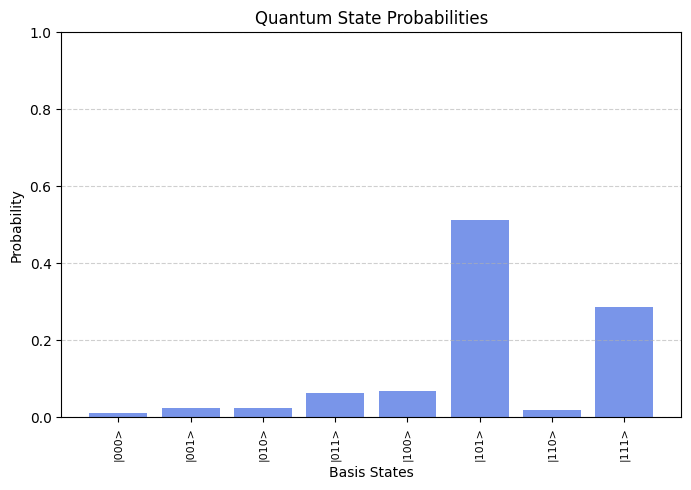

In [312]:
plot_quantum_state_probabilities(psi)

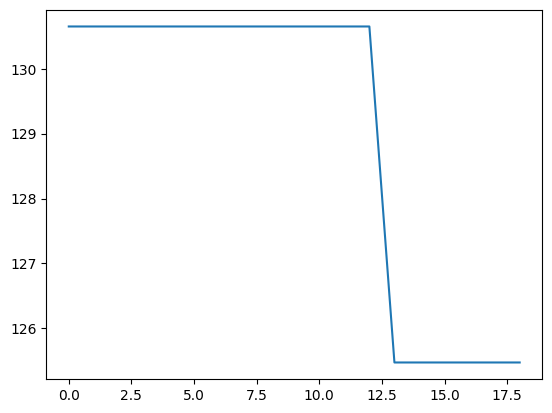

In [314]:
plt.plot(monitoring);

## 2. Pennylane

In [315]:
def sympy_to_pennylane(expr):
    terms = expr.as_ordered_terms()  # Get sum terms
    coeffs = []
    ops = []

    for term in terms:
        # Extract coefficient and operator part
        factors = term.as_ordered_factors()
        coefficient = 1
        op_list = []
        
        for factor in factors:
            if factor.is_Number:  # Numeric coefficient
                coefficient *= factor
            elif isinstance(factor, sp.Pow):  # Handle powers
                base, exponent = factor.args
                if isinstance(base, sp.Symbol) and base.name.startswith('Z_'):
                    qubit_index = int(base.name.split('_')[1]) - 1  # Convert to zero-based index
                    if exponent % 2 == 0:  # Z^2 = I
                        continue  # Ignore this factor (acts as identity)
                    else:
                        op_list.append(qml.PauliZ(qubit_index))  # Odd power -> still Z
            elif isinstance(factor, sp.Symbol) and factor.name.startswith('Z_'):  # Pauli Z term
                qubit_index = int(factor.name.split('_')[1]) - 1  # Convert to zero-based index
                op_list.append(qml.PauliZ(qubit_index))

        # Convert to a PennyLane tensor product (if multiple Z's)
        if op_list:
            tensor_op = op_list[0]
            for op in op_list[1:]:
                tensor_op = tensor_op @ op  # Correct way to construct tensor product
            ops.append(tensor_op)
            coeffs.append(float(coefficient))  # Ensure coefficient is a float
        else:
            # If only a constant term remains, use an identity operator
            ops.append(qml.Identity(0))  # Identity on any qubit (it’s a global constant term)
            coeffs.append(float(coefficient))

    return qml.Hamiltonian(coeffs, ops)

In [316]:
N = 21
nx = 1
ny = 2

Hf_expr = sp.expand(
    (
        N*sp.Symbol('I')
        - (sum(2**l * (sp.Symbol('I') - sp.Symbol(f'Z_{l}')) / 2 for l in range(1, nx+1)) + sp.Symbol('I'))
        * (sum(2**m * (sp.Symbol('I') - sp.Symbol(f'Z_{m+nx}')) / 2 for m in range(1, ny+1)) + sp.Symbol('I'))
    )**2
)

Hf = sympy_to_pennylane(Hf_expr).simplify()

In [317]:
Hf = qml.Hamiltonian(
    coeffs=[210,84,88,44,-20,-10,20,-16],
    observables=[qml.I([0,1,2]), qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(0)@qml.PauliZ(1), qml.PauliZ(0)@qml.PauliZ(2), qml.PauliZ(1)@qml.PauliZ(2), qml.PauliZ(0)@qml.PauliZ(1)@qml.PauliZ(2)]
)

In [318]:
num_wires = 3

H_c = Hf

H_m = sum(qml.PauliX(i) for i in range(num_wires))

In [319]:
dev = qml.device('default.qubit', wires=num_wires)

In [320]:
num_qaoa_layers = 3

def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_c)
    qaoa.mixer_layer(beta, H_m)

def circuit(gammas, betas):
    for w in range(num_wires):
        qml.Hadamard(w)

    qml.layer(qaoa_layer, num_qaoa_layers, gammas, betas)

@qml.qnode(dev)
def cost_function(params):
    circuit(gammas=params[:num_qaoa_layers], betas=params[num_qaoa_layers:])
    return qml.expval(H_c)

@qml.qnode(dev)
def circuit_state(params):
    circuit(gammas=params[:num_qaoa_layers], betas=params[num_qaoa_layers:])
    return qml.state()

### 2.1. GradientDescentOptimizer (Pennylane) - No bounding option

In [324]:
#Optimization

opt = qml.GradientDescentOptimizer()
steps = 1000

params = np.array([0.5]*num_qaoa_layers*2)


for _ in range(steps):
    params = opt.step(cost_function, params)

res = circuit_state(params)

In [325]:
psi = to_polar(sp.Matrix(res.tolist()))

In [326]:
params

tensor([-1640.06850769, -3984.47061919,   486.69596869,    18.05044285,
           23.87924382,   -19.34013332], requires_grad=True)

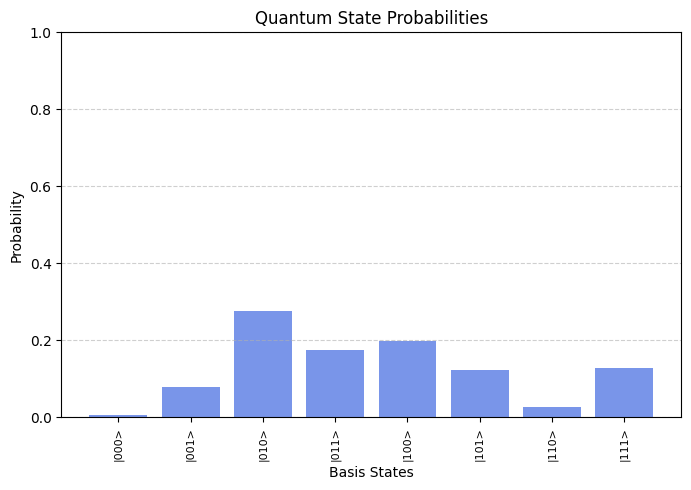

In [327]:
plot_quantum_state_probabilities(psi)

### 2.2. Nelder-Mead optimizer (Scipy)

In [328]:
bounds = [(0,2*np.pi)]*num_qaoa_layers*2

iters = 20
results = {}
monitoring = {}

for i in range(iters):

    gammas, betas = (np.random.rand(2,num_qaoa_layers) * np.pi*2).tolist()

    monitoring_i = []

    res = minimize(
        fun=cost_function,
        x0=gammas + betas,
        method='Nelder-Mead',
        bounds=bounds,
        callback=lambda intermediate_result: monitoring_i.append(intermediate_result.fun),
        options={
            #'disp': True,
            #'maxiter': 1000,
            'adaptive': True
        }
    )

    monitoring.update({i: monitoring_i})

    results[i] = {'fun': float(res.fun), 'params': res.x.tolist()}

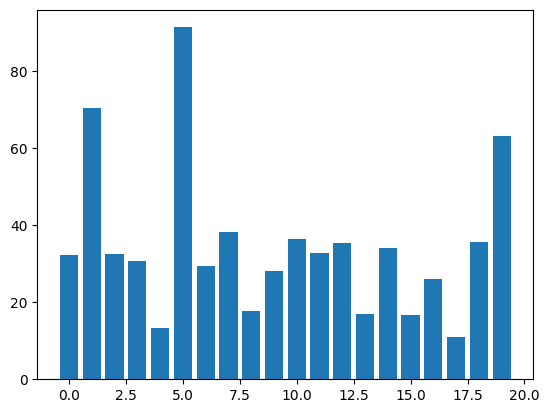

In [329]:
x = results.keys()
y = [item['fun'] for item in results.values()]
plt.bar(x, y);

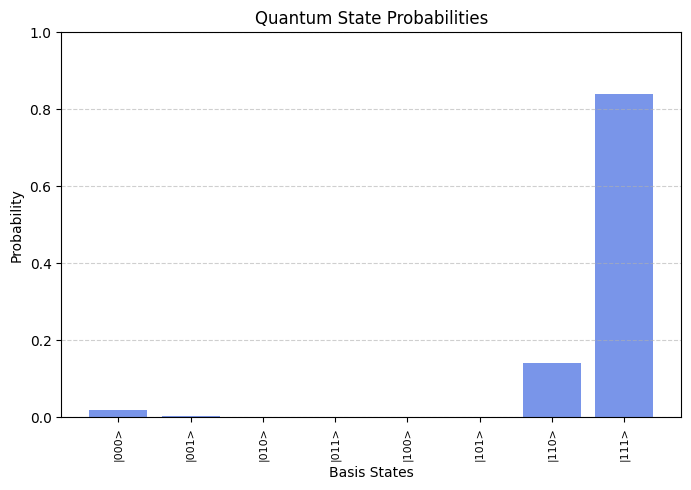

In [330]:
psi = circuit_state(results[4]['params'])
psi = to_polar(sp.Matrix(psi.tolist()))
plot_quantum_state_probabilities(psi)

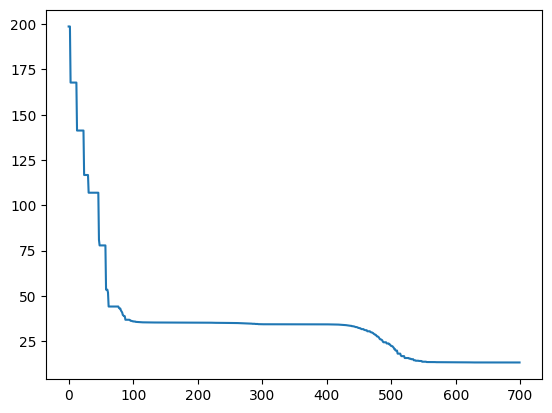

In [331]:
plt.plot(monitoring[4]);

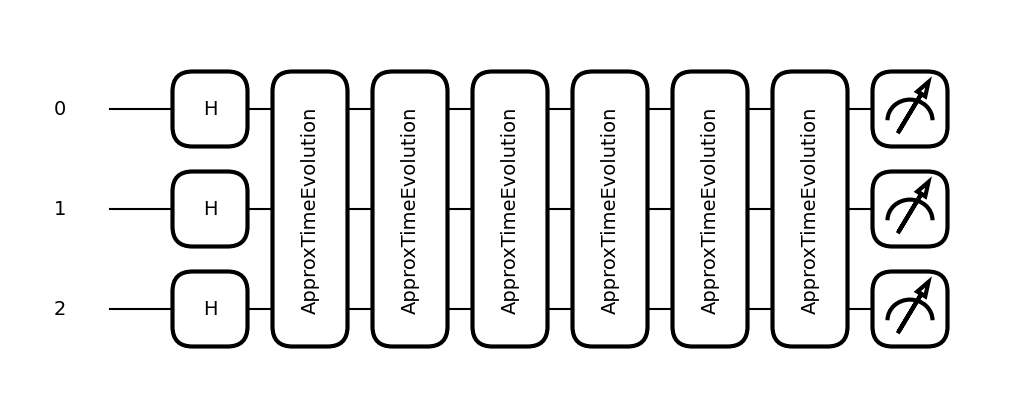

In [332]:
qml.draw_mpl(cost_function)(results[6]['params']);